# Mount from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12792 entries, 0 to 12791
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_name        12792 non-null  object
 1   question_vectors  12792 non-null  object
 2   image_vectors     12792 non-null  object
 3   answer            12792 non-null  object
dtypes: object(4)
memory usage: 1015.7+ KB


# create model

In [ ]:
question_input_layer = tf.keras.layers.Input((11,300))  # Input Model (for question)
images_input_layer = tf.keras.layers.Input((11,300)) # Input Model (for images)

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images_input_layer)

''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(question_input_layer)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
quesa = Concatenate()([quesa,imagica])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(1552,activation='softmax')(quesa)

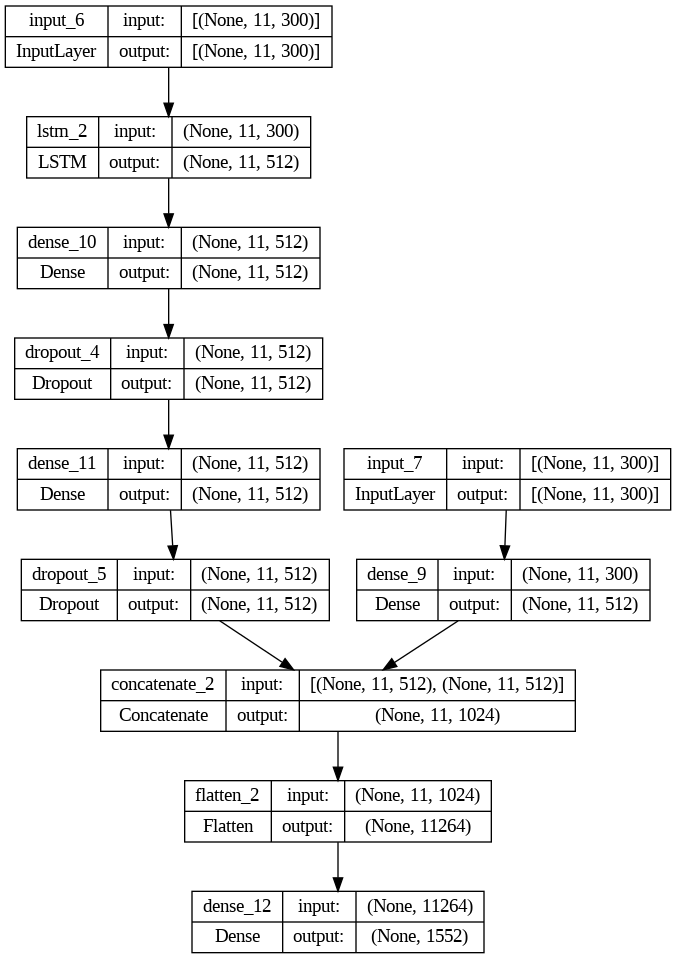

In [ ]:
model = Model([question_input_layer,images_input_layer],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss ='categorical_crossentropy',metrics=['accuracy'])

### prepare images data to the model

In [ ]:
data_image = np.zeros((len(final_data),11,300))
for i in range(len(final_data)):
  data_image[i] = final_data.loc[i]["image_vectors"]

### prepare question data to the model

In [ ]:
data_question = np.zeros((len(final_data),11,300))
for i in range(len(final_data)):
  data_question[i] = final_data.loc[i]["question_vectors"]

In [ ]:
data_image.shape, data_question.shape

((12792, 11, 300), (12792, 11, 300))

### prepare y_true data to the model

In [ ]:
number_answer = len((final_data["answer"].apply(lambda x : str(x).lower())).unique())
ans_classes = final_data["answer"].apply(lambda x : str(x).lower())

In [ ]:
final_data["answer"] = final_data["answer"].apply(lambda x : str(x).lower())

In [ ]:
label_dict = {label: i for i, label in enumerate(set(final_data["answer"]))}
num_classes = len(label_dict)
one_hot_labels = tf.keras.utils.to_categorical([label_dict[label] for label in ans_classes], num_classes=num_classes)
print(one_hot_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
one_hot_labels.shape

(12792, 1552)

### fit the model

In [ ]:
history = model.fit([data_image,data_question],one_hot_labels,epochs = 100,batch_size=32,verbose=1)

Epoch 1/100
400/400 [==============================] - 8s 12ms/step - loss: 7.1480 - accuracy: 0.3325
Epoch 2/100
400/400 [==============================] - 4s 11ms/step - loss: 4.1333 - accuracy: 0.3421
Epoch 3/100
400/400 [==============================] - 4s 10ms/step - loss: 3.8600 - accuracy: 0.3511
Epoch 4/100
400/400 [==============================] - 4s 11ms/step - loss: 3.7125 - accuracy: 0.3508
Epoch 5/100
400/400 [==============================] - 4s 11ms/step - loss: 3.6014 - accuracy: 0.3537
Epoch 6/100
400/400 [==============================] - 4s 10ms/step - loss: 3.5487 - accuracy: 0.3544
Epoch 7/100
400/400 [==============================] - 4s 11ms/step - loss: 3.5177 - accuracy: 0.3563
Epoch 8/100
400/400 [==============================] - 4s 11ms/step - loss: 3.4989 - accuracy: 0.3490
Epoch 9/100
400/400 [==============================] - 4s 10ms/step - loss: 3.4548 - accuracy: 0.3529
Epoch 10/100
400/400 [==============================] - 4s 10ms/step - loss: 3.443

### save model

In [ ]:
# Save the entire model to a single file
model.save('/content/drive/MyDrive/ComputerVisionProject/used_models/moreData_model.h5')

### Function to predict

In [ ]:
import json
# Read data from a JSON file
with open('/content/label_dict.json', 'r') as f:
    data_dict = json.load(f)

# Convert the data to a dictionary
label_dict = dict(data)

In [ ]:
def get_key(val):
    for key, value in label_dict.items():
        if val == value:
            return key

In [ ]:
def predict_answer(image_name, question):
    
    model = tf.keras.models.load_model('/content/drive/MyDrive/ComputerVisionProject/used_models/moreData_model.h5')

    
    image = read_images_as_array(image_name)
    question_vec = get_text_embeding_matrix(question)
    
    
    image_embedding = dimen_red(image_feature_extraction(image)).numpy().reshape(-1, 11, 300)
    question_embedding = np.array([question_vec])

    
    prediction = model.predict([image_embedding, question_embedding])

    
  
    predicted_index = np.argmax(prediction)
    predicted_answer = get_key(predicted_index)
    
    return predicted_answer,predicted_index


In [ ]:
data.loc[31]

image_name                   synpic23493.jpg
question      is \tthis a t1 weighted image?
answer                                   yes
Name: 31, dtype: object

In [ ]:
image_name = os.path.join(image_path, data.loc[31]["image_name"])
question = data.loc[31]["question"]

In [ ]:
predicted_answer,prediction = predict_answer(image_name, question)
print("predicted_answer  :",predicted_answer)

1/1 [==============================] - 0s 387ms/step
predicted_answer  : yes
